In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

In [6]:
# Get dataframe
df = pd.read_csv('data/processed_data.csv')
print(df.head())
prs_types = ['GM', 'WM', 'FC']

         IID  GM_SCORE  GM_ZSCORE  WM_SCORE  WM_ZSCORE  FC_SCORE  FC_ZSCORE  \
0  B32512144  0.000449   0.485442  0.000346   0.274337 -0.000026   0.489272   
1  B11816003  0.000047  -0.088311  0.001022   1.094869 -0.000368   0.112118   
2  B69547090  0.001152   1.491210  0.000323   0.245619  0.000650   1.236953   
3  B87467726 -0.000271  -0.543868 -0.000979  -1.335242 -0.000064   0.447456   
4  B92485577 -0.000489  -0.854842  0.000161   0.048866 -0.001789  -1.458315   

   pTau217  FCTOTAL96    BP40  ...  FP42/TP42    TP40   TP42  TP42/TP40  \
0      NaN       82.0   74.71  ...      0.251  135.29  11.01      0.081   
1      NaN       74.0  172.13  ...      0.628  356.85  83.66      0.234   
2    0.157       79.0   64.90  ...      0.368  129.99   9.62      0.074   
3    0.242       87.0   64.54  ...      0.195  115.45  25.10      0.217   
4    0.304       77.0  115.53  ...      0.472  252.50  18.56      0.073   

   AMYLB40  AMYLB42  APOE4  GFAP   NF-L   TPP181  
0    0.193    19.88    

## Basic data analysis

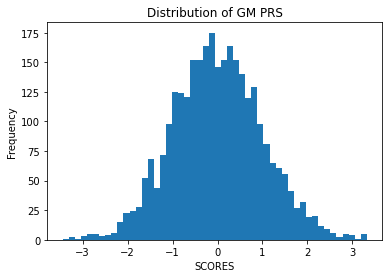

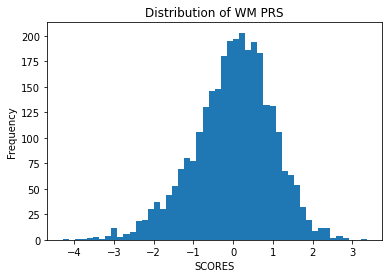

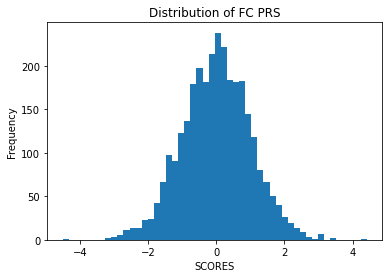

In [8]:
# Show distributions of ZSCORES for each prs type
for prs_type in prs_types:
    plt.hist(df['{}_ZSCORE'.format(prs_type)], bins=50)
    plt.title('Distribution of {} PRS'.format(prs_type))
    plt.xlabel('SCORES')
    plt.ylabel('Frequency')
    plt.show()

In [20]:
# Calculate Pearson correlation between PRS and different values
info_cols = ['IID', 'WM_SCORE', 'WM_ZSCORE', 'GM_ZSCORE', 'GM_SCORE', 'FC_SCORE', 'FC_ZSCORE']
factors = [col for col in df.columns if col not in info_cols]

# Generate a dataframe with three columns for each PRS type

df_factors = pd.DataFrame(columns=['Factor']+ [prs + '_corr' for prs in prs_types]
                          + [prs + '_pval' for prs in prs_types])
for factor in factors:
    # Create new empty row for factor
    row = {'Factor': factor}
    for prs in prs_types:
        df_p = df[['{}_ZSCORE'.format(prs), factor]].copy().dropna()
        corr, p_val = pearsonr(df_p['{}_ZSCORE'.format(prs)], df_p[factor])
        row[prs+'_corr'], row[prs+'_pval'] = corr, p_val
    df_factors = pd.concat([df_factors, pd.DataFrame([row])], ignore_index=True)

# Show results
print(df_factors)

       Factor        GM        WM        FC
0     pTau217  0.055725 -0.016918 -0.040871
1   FCTOTAL96  0.038819   0.02291 -0.028694
2        BP40  0.010867   -0.0071 -0.019471
3        BP42 -0.002056  -0.01871 -0.041425
4        FP40  0.026181  0.003043 -0.012208
5   FP40/TP40 -0.008666  0.005969 -0.008674
6        FP42  0.010712 -0.003421 -0.022188
7   FP42/FP40  0.007732 -0.001948 -0.016977
8   FP42/TP42 -0.019014  0.023904  -0.01947
9        TP40   0.01464 -0.009015 -0.021949
10       TP42   0.00077 -0.019042 -0.040201
11  TP42/TP40  0.009784  0.035876 -0.008507
12    AMYLB40   0.03467  0.014436 -0.019249
13    AMYLB42  0.033751  0.020866 -0.020241
14      APOE4  0.005298 -0.070921 -0.056216
15      GFAP   0.031852 -0.007254  0.018046
16      NF-L  -0.002273 -0.014324  0.014307
17     TPP181  0.036384 -0.043157  0.036702
       Factor        GM        WM        FC
0     pTau217  0.130942  0.646781  0.268129
1   FCTOTAL96  0.033199  0.208907  0.115503
2        BP40  0.581726  0.71891